# Uncertainty for unseen categories in deep learning

We investigate uncertainty in deep learning prediction. In particular, we are interested in how confident a neural network classifier is in making predictions for a category it has not seen in training, and therefore will not classify correctly. To this end, we utilise Bayesian neural networks using Monte Carlo (MC) dropout and variational inference (VI) on the Fashion MNIST dataset.

In [125]:
# Imports

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version {tfp.__version__}")

TensorFlow version: 2.8.0
TensorFlow Probability version 0.16.0


In [126]:
tfp.__version__

'0.16.0'

In [127]:
# Load Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [128]:
print(X_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [129]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [130]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

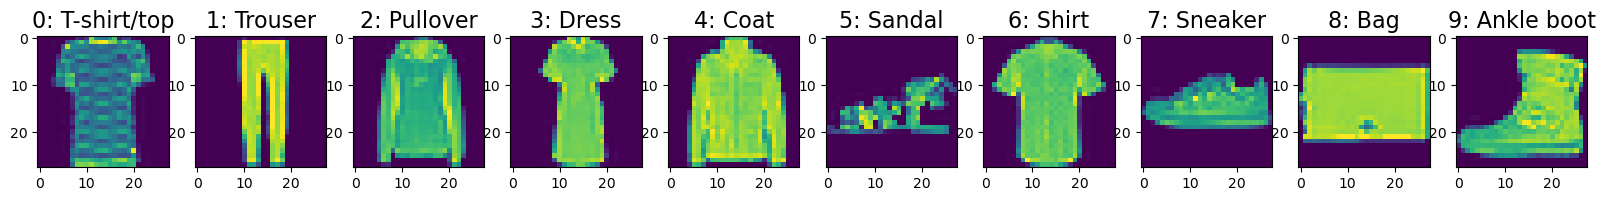

In [131]:
# Let's peek what the items look like
np.random.seed(1)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train_full))):
    rand=np.random.choice(np.where(y_train_full==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train_full[rand]
    plt.imshow(img[0,:,:,])
    plt.title(str(y_train_full[rand][0])+ ": " +class_names[i],fontsize=16)

In [132]:
# Let's remove one class and make it "unknown"
from copy import deepcopy
# Let's remove 'Trousers' which is at index 1
unknown_class = 1 
# Delete all instances of 'Trousers'. The remaining ones are 'known' classes.
y_train_known = np.delete(y_train_full,np.where(y_train_full==unknown_class)[0])
X_train_known = np.delete(X_train_full,np.where(y_train_full==unknown_class)[0],axis=0)
class_names_known = deepcopy(class_names)
del class_names_known[unknown_class]
print(y_train_known.shape)
print(X_train_known.shape)
print(class_names)
print(class_names_known)

(54000,)
(54000, 28, 28)
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
['T-shirt/top', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [133]:
# Create train and validation sets from "known" training sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_known, y_train_known, test_size=0.3, random_state=42)

In [134]:
# Normalize features for NN training
X_train, X_valid = ( (X_train/255.) -0.5 )*2, ( (X_valid/255.) -0.5 )*2.

In [135]:
# Normalize also test features
X_test=((X_test/255)-0.5)*2

In [136]:
# One-hot encode response
y_train_onehot = np.array(pd.get_dummies(y_train))
y_valid_onehot = np.array(pd.get_dummies(y_valid))

In [137]:
pd.Series(y_train).nunique()

9

In [138]:
y_train_onehot.shape

(37800, 9)

# MC Dropout

In [139]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model

# Create a separate class for MCDropout layers that can be used also during test, since
# our network has also BatchNormalization layers that behave different during training and test
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [140]:
# Mini-batch size
BATCH_SIZE = 32    
    
# Define model
input_ = Input(shape=(28,28,1))
x = Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'selu')(input_)
x = MCDropout((0.3))(x)
x = Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(32,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(64,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(128,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(9, activation = 'softmax')(x)
model_mc = Model(inputs=[input_], outputs=[x])

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 mc_dropout_14 (MCDropout)   (None, 28, 28, 8)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 mc_dropout_15 (MCDropout)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                           

In [141]:
history_mc=model_mc.fit(X_train, y_train_onehot,
                        validation_data=(X_valid, y_valid_onehot),
                        batch_size=BATCH_SIZE,
                        epochs=500,
                        verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint("mc_dropout_model_no_trousers.h5", save_best_only=True)])

Epoch 1/500
1182/1182 [==============================] - 36s 29ms/step - loss: 0.8437 - accuracy: 0.6888 - val_loss: 0.5863 - val_accuracy: 0.7833
Epoch 2/500
1182/1182 [==============================] - 33s 28ms/step - loss: 0.5338 - accuracy: 0.8057 - val_loss: 0.4906 - val_accuracy: 0.8219
Epoch 3/500
1182/1182 [==============================] - 36s 31ms/step - loss: 0.4644 - accuracy: 0.8324 - val_loss: 0.4043 - val_accuracy: 0.8541
Epoch 4/500
1182/1182 [==============================] - 38s 33ms/step - loss: 0.4279 - accuracy: 0.8469 - val_loss: 0.4038 - val_accuracy: 0.8565
Epoch 5/500
1182/1182 [==============================] - 34s 29ms/step - loss: 0.4011 - accuracy: 0.8564 - val_loss: 0.3969 - val_accuracy: 0.8591
Epoch 6/500
1182/1182 [==============================] - 35s 30ms/step - loss: 0.3814 - accuracy: 0.8642 - val_loss: 0.3670 - val_accuracy: 0.8661
Epoch 7/500
1182/1182 [==============================] - 34s 29ms/step - loss: 0.3617 - accuracy: 0.8717 - val_loss: 0

In [142]:
df_hist = pd.DataFrame(history_mc.history)

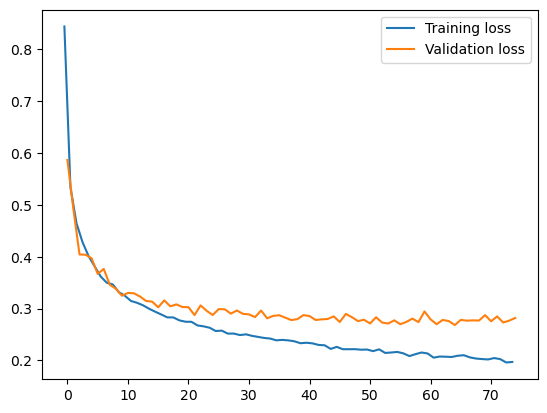

In [143]:
plt.plot(np.arange(len(df_hist.loss))-0.5, df_hist.loss, label="Training loss")
plt.plot(np.arange(len(df_hist.loss)), df_hist.val_loss, label="Validation loss")
plt.legend()

# Bayesian neural network using variational flip-out layers

In [33]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

# Define model
input_ = Input(shape=(28,28,1))
x = tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(input_)
x = tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(32,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(64,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = tfp.layers.Convolution2DFlipout(128,kernel_size=(3,3),padding="same", activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = tfp.layers.DenseFlipout(100, activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = BatchNormalization()(x)
x = tfp.layers.DenseFlipout(100, activation = 'selu', kernel_divergence_fn=kernel_divergence_fn)(x)
x = BatchNormalization()(x)
x = tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn)(x)
model_vi = Model(inputs=[input_], outputs=[x])

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_vi.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_flipout_15 (Conv2DFl  (None, 28, 28, 8)        152       
 ipout)                                                          
                                                                 
 conv2d_flipout_16 (Conv2DFl  (None, 28, 28, 16)       2320      
 ipout)                                                          
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_flipout_17 (Conv2DFl  (None, 14, 14, 32)       9248      
 ipout)                                                    

In [35]:
history_vi=model_vi.fit(X_train, y_train_onehot,
                        validation_data=(X_valid, y_valid_onehot),
                        batch_size=BATCH_SIZE,
                        epochs=200,
                        verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint("vi_dropout_model_no_trousers.h5", save_best_only=True)])

Epoch 1/1000
1182/1182 [==============================] - 61s 51ms/step - loss: 8.2261 - accuracy: 0.7906 - val_loss: 7.8346 - val_accuracy: 0.8327
Epoch 2/1000
1182/1182 [==============================] - 61s 51ms/step - loss: 7.5232 - accuracy: 0.8360 - val_loss: 7.1696 - val_accuracy: 0.8535
Epoch 3/1000
1182/1182 [==============================] - 73s 62ms/step - loss: 6.8507 - accuracy: 0.8558 - val_loss: 6.5270 - val_accuracy: 0.8575
Epoch 4/1000
1182/1182 [==============================] - 62s 53ms/step - loss: 6.2304 - accuracy: 0.8609 - val_loss: 5.9307 - val_accuracy: 0.8677
Epoch 5/1000
1182/1182 [==============================] - 65s 55ms/step - loss: 5.6614 - accuracy: 0.8688 - val_loss: 5.3953 - val_accuracy: 0.8714
Epoch 6/1000
1182/1182 [==============================] - 61s 52ms/step - loss: 5.1495 - accuracy: 0.8756 - val_loss: 4.9156 - val_accuracy: 0.8762
Epoch 7/1000
1182/1182 [==============================] - 60s 51ms/step - loss: 4.6965 - accuracy: 0.8776 - val_

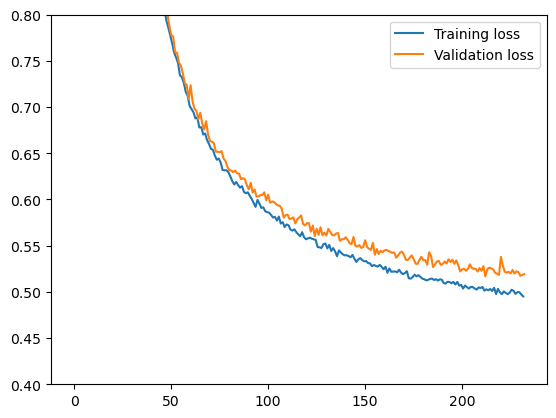

In [99]:
df_hist_vi = pd.DataFrame(history_vi.history)
plt.plot(np.arange(len(df_hist_vi.loss))-0.5, df_hist_vi.loss, label="Training loss")
plt.plot(np.arange(len(df_hist_vi.loss)), df_hist_vi.val_loss, label="Validation loss")
plt.ylim([0.4,0.8])
plt.legend()

In [1]:
# TODO: probability calibration

In [144]:
# Get indices for known and unknown classes for splitting the test sets
known_idx=np.where(y_test != unknown_class)[0]
unknown_idx=np.where(y_test == unknown_class)[0]

In [145]:
# Split the test sets to known and unknown parts
X_test_known = X_test[known_idx]
y_test_known = y_test[known_idx]

X_test_unknown = X_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

In [146]:
# Predicted class probabilities (just a single run for testing)
p_pred_known_mc = model_mc.predict(X_test_known)

In [147]:
# Predicted class probabilities (just a single run for testing)
p_pred_known_vi = model_vi.predict(X_test_known)

In [148]:
for p in (p_pred_known_mc, p_pred_known_vi):
    idx_pred_known = np.argmax(p, axis=1)
    pred_classes = np.array([class_names_known[i] for i in idx_pred_known])
    correct_classes = np.array([class_names[i] for i in y_test_known])
    # Accuracy
    print(np.mean(pred_classes == correct_classes))

0.8987777777777778
0.8837777777777778


# Predictions for an unseen class

In [149]:
# Let's pick a random instance for repeated prediction
np.random.seed(123)
random_sample_known=np.random.choice(range(0,len(X_test_known)),1)
np.random.seed(456)
random_sample_unknown=np.random.choice(range(0,len(X_test_unknown)),1)

(0.0, 1.0)

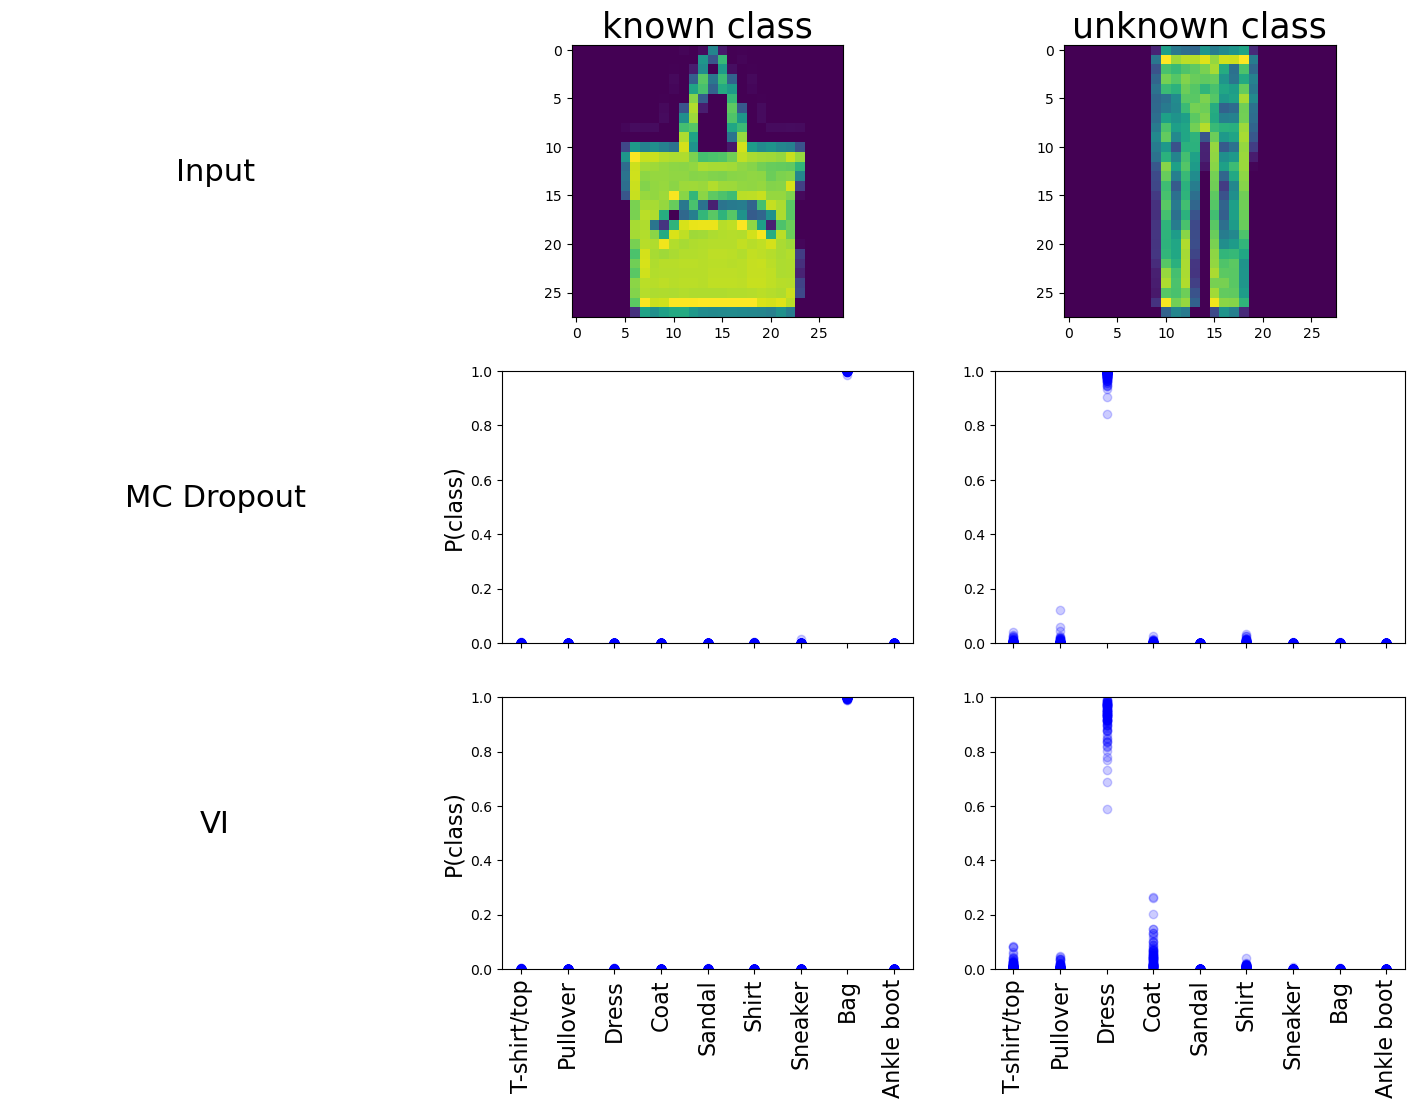

In [150]:
num_samples = 100

plt.figure(figsize=(18,12))
plt.subplot(3,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,2)
plt.imshow(np.squeeze(np.array(((((X_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(3,3,3)
plt.imshow(np.squeeze(np.array(((((X_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(3,3,4)
plt.axis('off')
plt.text(0.5,0.5, "MC Dropout",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,5)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_mc.predict(X_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=[""]*9,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(3,3,6)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_mc.predict(X_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=[""]*9,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])

plt.subplot(3,3,7)
plt.axis('off')
plt.text(0.5,0.5, "VI",fontsize=22,horizontalalignment='center')
plt.subplot(3,3,8)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_vi.predict(X_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(3,3,9)
for i in range(0, num_samples):
  plt.scatter(range(0,9),model_vi.predict(X_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])

# Conclusions
Above on the left we see how both MC Dropout and VI are able to predict "Bag" correctly with small uncertainty (low variance in predicted probability). On the right, on the other hand, we feed an instance of the "Trousers" class we excluded from training. We see higher uncertainty in the predictions as expected, more so for VI that MC Dropout.

For the next steps, we would like include probability calibration and investigate other uncertainty measures than variance of the predictions.